## Magnetotelluric (MT) inversion
### Background
Let's treat the magnetotelluric investigation, i.e. measuring electric and magnetic fields over a wide frequency ($\omega$) range to make a depth sounding. From the impedance $Z=E/H$ (e.g. $E_x$ and $H_y$) we compute the apparent resistivity
$$ \rho^a(\omega) = \frac{1}{\omega\mu}|Z|^2 $$
and phase
$$ \phi(\omega) = \tan^{-1}\frac{Z''}{Z'} $$
We plot the data in two separate plots with the periods as vertical axis going down (increasing penetration depth):

In [1]:
using PyPlot
function plotMTsounding(T, rhoa, phi)
    # plot apparent resistivity and phase over period in two subplots
    fig, ax = subplots(ncols=2, sharey=true)
    ax[1].loglog(rhoa, T)
    ax[1].invert_yaxis()
    ax[2].semilogy(phi*180/pi, T)
    ax[1].set_title("apparent resistivity")
    ax[2].set_title("phase")
    ax[1].set_xlabel(L"$\rho$ ($\Omega$m)")
    ax[2].set_xlabel(L"$\phi$ (°)")
    ax[1].set_ylabel(L"$T$ (s)")
    ax[1].grid()
    ax[2].grid()
end;

### Forward computation
The forward algorithm is described by Wait's (1955) algorithm. It returns apparent resistivity and phase as separate vectors for a given resistivity/thickness combination.

In [2]:
function mt1dfwd(period, r, d)
    # MT forward computation with Wait's algorithm
    # = mt1dfwd(resistivities,thicknesses,periods)
    my0 = 4*pi*1e-7;
    omega = 2 *pi ./ period;
    k1 = sqrt.(im * omega * my0 / r[1]);
    g = 1
    nlay=min(length(r),length(d)+1)
    for k = nlay-1:-1:1;    
        k1 = sqrt.(im * omega * my0 / r[k])
        k2 = sqrt.(im * omega * my0 / r[k+1])
        th = tanh.(k1*d[k])
        g = (g.*k2 + k1.*th) ./ (k1 + g.*k2.*th);    
    end
    z = im * omega ./ (k1 .* g)

    rhoa = my0 ./ omega .* abs.(z).^2
    phi = angle.(z)
    return rhoa, phi
end;

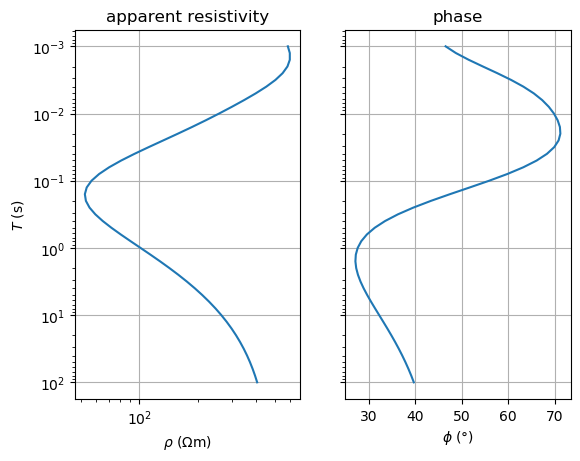

In [4]:
# Test the forward operator with a 3-layer model
rho = [500, 20, 500]
thk = [500, 500]
T = 10 .^ (-3:0.1:2)  # 1ms to 100s (typical AMT)
rhoa, phi = mt1dfwd(T, rho, thk)
plotMTsounding(T, rhoa, phi)

The good conductor shows with increased phases at about 10-20ms and decreased $\rho ^a$ at about 100-200ms. Play around to get a feeling how different models affect the curves.

In [5]:
# define a fixed-thickness forward operator for Occam inversion
thkVec = ones(30) * 50
mt1dsmooth(T, rho) = mt1dfwd(T, rho, thkVec);
r1, p1 = mt1dsmooth(T, ones(21)*20);

### Sensitivity

In [7]:
function MT1dSens(T, resistivity)
    rhoa, phi = mt1dsmooth(T, resistivity)
    Srhoa = zeros(length(T), length(resistivity))
    Sphi = zeros(length(T), length(resistivity))
    for i = 1:numlay
        resistivity1 = resistivity * 1.0 # make a copy!
        resistivity1[i] *= 1.1  # change by 10%
        rhoa1, phi1 = mt1dsmooth(T, resistivity1)
        Srhoa[:, i] = (rhoa1 - rhoa) ./ (resistivity1[i] - resistivity[i])
        Sphi[:, i] = (phi1 - phi) ./ (resistivity1[i] - resistivity[i])
    end
    return Srhoa, Sphi
end

MT1dSens (generic function with 1 method)

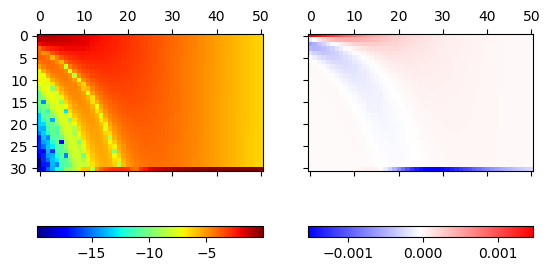

In [8]:
numlay = length(thkVec) + 1
resistivity = ones(numlay) * 100
Srhoa, Sphi = MT1dSens(T, resistivity)
fig, ax = subplots(ncols=2, sharey=true)
img = ax[1].matshow(transpose(log.(abs.(Srhoa))), cmap="jet");
colorbar(img, ax=ax[1], orientation="horizontal");
img = ax[2].matshow(transpose(Sphi), cmap="bwr");
colorbar(img, ax=ax[2], orientation="horizontal");

### Equivalency

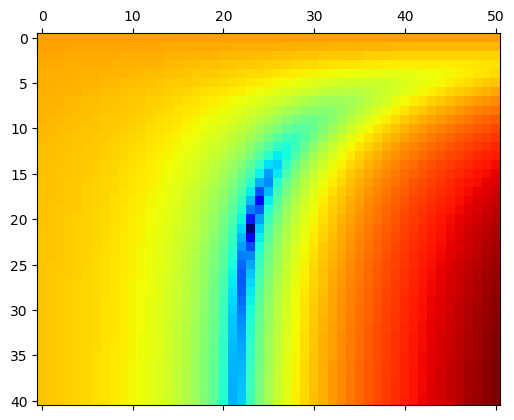

In [7]:
using LinearAlgebra
rho = [100.0, 1000.0, 100.0]  # resistivity vector (resistive anomaly)
thk = [500.0, 500.0]
rhoa, phi = mt1dfwd(T, rho, thk)
rhovals = 10 .^ (2:0.05:4)
thkvals = 10 .^ (2:0.03:3.5)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    rho[2] = rhovals[i]
    for j = 1:length(thkvals)
        thk[2] = thkvals[j]
        rhoa1, phi1 = mt1dfwd(T, rho, thk)
        Phi[i, j] = norm(rhoa1-rhoa)
    end
end

matshow(log.(Phi))
set_cmap("jet")

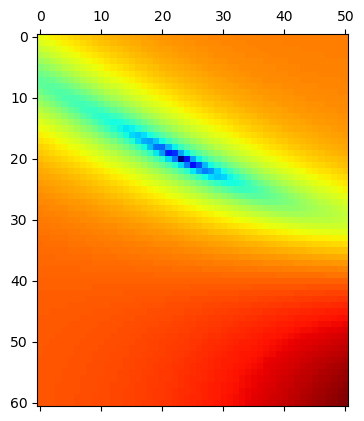

In [8]:
using LinearAlgebra
rho = [100.0, 10.0, 100.0]  # resistivity vector (conductive anomaly)
thk = [500.0, 500.0]
rhoa, phi = mt1dfwd(T, rho, thk)
rhovals = 10 .^ (0:0.05:3)
thkvals = 10 .^ (2:0.03:3.5)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    rho[2] = rhovals[i]
    for j = 1:length(thkvals)
        thk[2] = thkvals[j]
        rhoa1, phi1 = mt1dfwd(T, rho, thk)
        Phi[i, j] = norm(rhoa1-rhoa)
    end
end

matshow(log.(Phi))
set_cmap("jet")

### Inversion
Now we (i.e. you) go for inversion. 

Tasks:
1. Compute synthetic data using using a three-layer case (e.g. a conductor)
1. Add Gaussian noise:
    * 3% (relative) to the apparent resistivity
    * 1° (absolute) to the phases
1. Use the sensitivity above to compute the Jacobian matrix for apparent resistivity only, using logarithmic $\rho$ and $\rho^a$ transformations.
1. Carry out an Occam-type inversion with fixed discretization and first-order smoothness constraints, first using apparent resistivity only. 
    * scale the inverse problem by the inverse of the error model
    * Adjust the regularization strength with the discrepancy principle ($\chi^2=1$).
1. Compute the model resolution matrix and the data information matrix. Display the whole matrices and their diagonals (over depth and period, respectively).
1. Extend the inversion to using both $\rho^a$ and $\phi$ values by concatenating both vectors (and also concatenating the Jacobian matrices). Keep making use of logarithmic resistivities but linear phases.
    * Combine the data to a long vector of $\log\rho^a$ and $\phi$, the error model likewise.
    * Write a Jacobian function that scales the individual sensitivities and concatenates them.
    * Scale the Jacobian by the inverse of the (now combined!) error model. 
    * Again adjust the regularization parameter so that $\chi^2=1$.
1. Compute model resolution and data information matrices. Is the model resolution improved by adding the phase data? How are the individual resistivity and phase data are connected to each other and to neighboring periods?
1. Do a Marquardt-type inversion of a three-layered Earth model (5 parameters):
    * start with a homogeneous model of mean apparent resistivity
    * use a damping scheme (identity matrix), if necessary, decrease the damping parameter by a certain factor in every iteration
    * compute the model resolution matrix and assess the reliability of the retrieved parameters

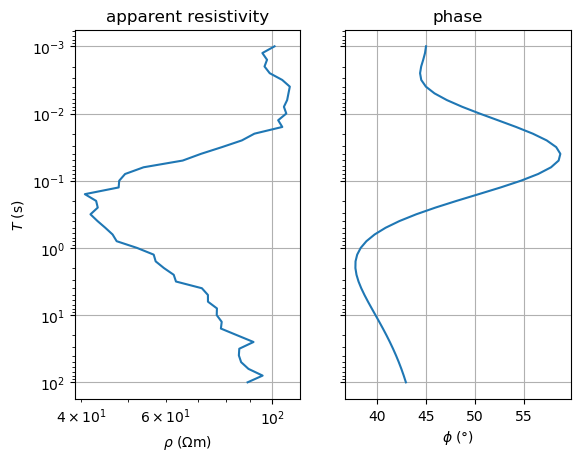

In [9]:
# Test the forward operator with a 3-layer model
rho = [100, 20, 100]
thk = [500, 500]
T = 10 .^ (-3:0.1:2)  # 1ms to 100s (typical AMT)
rhoa_syn, phi_syn = mt1dfwd(T, rho, thk)
#errmodel = ones(length(rhoa_syn),1) .* 0.03
errmodel = 0.03 .* rhoa_syn
rhoa_syn += randn(size(rhoa_syn)) .* errmodel #.* rhoa_syn 
plotMTsounding(T, rhoa_syn, phi_syn)

Die Abbildungen des scheinbaren spezifischen Widerstandes und der zugehörigen Phase zeigen die typischen Merkmale für eine gutleitfähige Schicht mit $\rho^a = 20 ~ \Omega m$, die durch zwei schlechtleitende Schichten $\rho^a = 100 ~ \Omega m$ eingeschlossen ist. Die erste schlechtleitende Schicht zeichnet sich durch hohe Werte des scheinbaren spezifischen Widerstandes von $10^{-3}s$ bis ca. $2 \cdot 10^{-2} s$. Größere Periodendauern von $10^{-1}s$ bis ca. $10 ~s$ der eindringenden eletkromagnetischen Welle registrieren die gutleitende Schicht. Der scheinbare spezifische Widerstand erreicht in diesem Abschnitt der Sondierungskurve die niedrigsten Werte. Bereits ab ca. $2 \cdot 10^{-2} s$ beginnt die Sondierungskurve zu fallen, sodass ab diesem Wert der erste Schichtübergang stattfindet. Zwischen $10^{-2} s$ und $10^{-1} s$ erreicht die Kurve der Phase das Maximum mit $68°$ und zeigt durch diesen Phasenanstieg die Schichtgrenze an. Ein abschließendes Absinken der Kurve bis ca. $10 ~s$ bestimmt die gutleitende Schicht. Ab diesem Wert ist wie in der Sondierungskurve des scheinbaren spezifischen Widerstandes der zweite Schichtübergang gekennzeichnet. In der Sondierungskurve nehmen die Widerstände permanent zu, sodass die Werte sich wieder der schleitenden dritten Schicht annähern. Gleiches gilt für die Kurve der Phase. Die Werte verzeichen nach dem Minimum von $34°$ auch hier einen Anstieg zu dem Anfangswert der ersten schlechtleitenden Schicht mit $45°$. Während des Verlaufs der Sondierungskurve sind immer wieder Ausschläge zu erkennen, die durch das angewendeten Rauschen entstehen. Das verwendete Rauschen für die Phase ist im Abschnitt 5 abgebildet.

In [10]:
#resistivity = ones(numlay) * 100
using LinearAlgebra  # Diagonal
function MT1dSensLog(T, resistivity)
    rhoa, phi = mt1dsmooth(T, resistivity)
    Srhoa, Sphi = MT1dSens(T, resistivity)
    Srho = Diagonal(1.0 ./ rhoa) * Srhoa * Diagonal(resistivity)
    return Srho
end

MT1dSensLog (generic function with 1 method)

## Occam korrekt

In [11]:
function OccamTest(Sens, C, lambda, d , error)
#function OccamTest(Sens, C, lambda, d , rhoa_syn, error)
    
    ST = transpose(Sens)
    #STd = ST * ((rhoa_syn .- d) ./ error) 
    STd = ST * (d ./ error) 
    CTCl = transpose(C) * C .* lambda^2
    model = inv(ST * Sens + CTCl) * STd 
    
    return model
    
end 

OccamTest (generic function with 1 method)

### Regularisierung

In [173]:
resistivity = ones(length(T)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)

C = zeros(length(T) - 1, length(T))
for i = 1:length(T)-1,
    C[i, i] = -1
    C[i, i+1] = +1
end

lambdaVector = 10 .^ range(-2, 2, step=0.1)
l = length(lambdaVector)
n = 10

deltamodel = zeros(n)

modelNorm1 = zeros(n)
residualNorm1 = zeros(n)
#modelNorm = zeros(n*l)
#residualNorm = zeros(n*l)
residual = zeros(n)
chi1 = zeros(n)
chi = zeros(n)
chi_lam = zeros(l,n)
modelNorm = zeros(l,n)
residualNorm = zeros(l,n)

numlay = length(thkVec) + 1
Sens = MT1dSensLog(T, resistivity)
Sens = Sens ./ errmodel


for j = 1:l
    
    resistivity = ones(length(T)) * 100
    rhoa, phase = mt1dsmooth(T, resistivity)

    lambda = lambdaVector[j]
    
    for i = 1:n
        
   
        d = log.(rhoa_syn) .- log.(rhoa)
    
        deltamodel = OccamTest(Sens, C, lambda, d, errmodel)
    
        resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
        rhoa, phase = mt1dsmooth(T, resistivity) 
    
        modelNorm1[i] = norm(C * rhoa)
        residual = (Sens * log.(rhoa) .- log.(rhoa_syn)) ./ errmodel
        residualNorm1[i] = norm(residual)
        chi1 = sum(residual.^2) / length(rhoa)
        
        chi[(i-1)+1] = chi1
    
    end
    
    #residualNorm[((n*(j-1))+1):(n*j)] = residualNorm1
    #modelNorm[((n*(j-1))+1):(n*j)] = modelNorm1
    
    chi_lam[j,1:end] = chi
    
    modelNorm[j,1:end] = modelNorm1
    residualNorm[j,1:end] = residualNorm1
    
end


In [174]:
lambda_ind = argmin(abs.(chi_lam .- 1))
#lambda_optline = minimum(abs.(delta_lam))
lambda_opt = lambdaVector[lambda_ind[1]]

0.3981071705534972

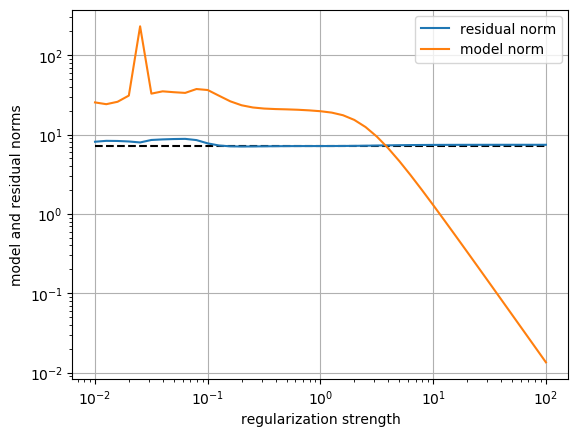

In [175]:
loglog(lambdaVector, residualNorm[:,lambda_ind[2]], label="residual norm")
loglog(lambdaVector, modelNorm[:,lambda_ind[2]], label="model norm")
hlines(sqrt(length(rhoa)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

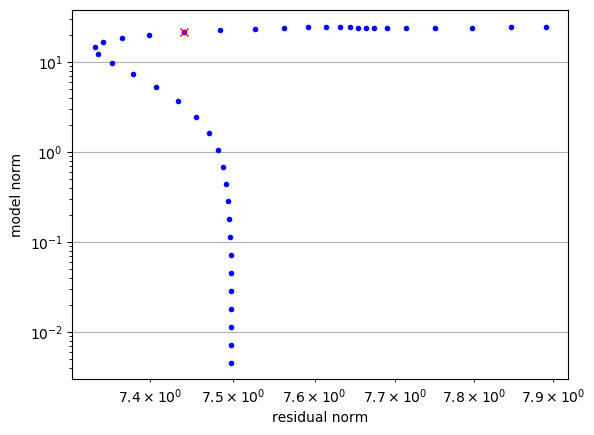

In [22]:
#print("Optimum p after discrepancy principle: ", pp)
loglog(residualNorm[:,1], modelNorm[:,1], "b.")
loglog(residualNorm[lambda_ind[1]], modelNorm[lambda_ind[1]], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

### Occam-Inversion

1.0854646616185926

1.0169346656814915

1.0005974198819647

1.0116713829338022

1.0127232327246076

1.0108130803062438

1.0102429336082894

1.0100406741540455

1.00973945827514

1.0094546813560787

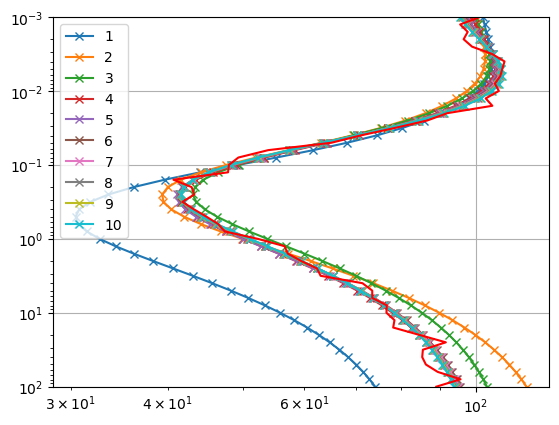

In [195]:
using Statistics
resistivity = ones(length(T)) * 100
#lambda = lambdaVector[pp] 
lambda = lambda_opt
#lambda = 0.15
#lambda = 0.001
rhoa = zeros(n)
#modelres = zeros(n)

rhoa, phase = mt1dsmooth(T, resistivity)

l = 10

modelNorm = zeros(l)
residualNorm = zeros(l)
residual = zeros(l)
chi = zeros(l)
deltamodel = zeros(l)
d = zeros(length(rhoa))
misfit = zeros(l,length(rhoa))

numlay = length(thkVec) + 1
Sens = MT1dSensLog(T, resistivity)
Sens = Sens ./ errmodel

for i = 1:l
    
    d = log.(rhoa_syn) .- log.(rhoa)
    misfit[i,1:end] = d./errmodel
    
    deltamodel = OccamTest(Sens, C, lambda, d, errmodel)
    
    #deltam = (log.(rhoa_syn) .- modelres) ./ errmodel
    
    resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
    rhoa, phase = mt1dsmooth(T, resistivity) 
    
    #resistivity = resistivity + deltam  # add line search
    #rhoa, phase = mt1dsmooth(T, resistivity)

    modelNorm[i] = norm(C * rhoa)
    #residual = (Sens * rhoa .- rhoa_syn) ./ errmodel
    residual = (Sens * log.(rhoa) .- log.(rhoa_syn)) ./ errmodel
    residualNorm[i] = norm(residual)
    chi[i] = sum(residual.^2) / length(rhoa)
    display(chi[i])
    
    #display(sqrt(mean(((rhoa_syn .- rhoa)./rhoa_syn).^2)) * 100)
    
    loglog(rhoa, T, marker="x", label=string(i))

end


loglog(rhoa_syn, T, "r-")
ylim(maximum(T), minimum(T))
grid();
legend();

### Misfit

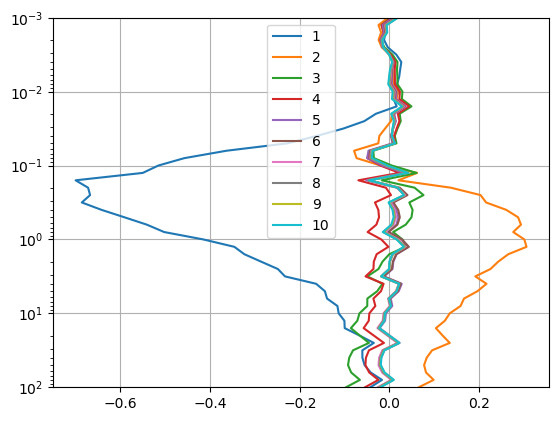

In [196]:
for i = 1:l
    
    semilogy(misfit[i,1:end], T, label=string(i))

end

grid();
legend();
ylim(maximum(T), minimum(T));

### Auflösungsmatrizen

#### Modellauflösungsmatrix

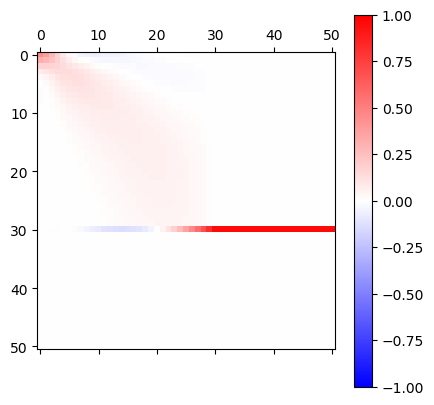

PyObject <matplotlib.colorbar.Colorbar object at 0x14cbd6310>

In [197]:
#Sens = MT1dSensLog(T, resistivity)
#Srhoa, Sphi = MT1dSens(T, resistivity)
lambda = lambda_opt 
STS = transpose(Sens) * Sens
CTC = transpose(C) * C
RM = pinv(STS + CTC .* lambda^2) * (STS)
#showModel(reshape(diag(RM),(nx,ny)), nx, ny, false)
matshow(transpose(RM))
#matshow(transpose(diag(RM)))
clim(-1, 1)
set_cmap("bwr")
colorbar()

Die Darstellung der Modellauflösungsmatrix $\mathbf R^M_{ij}$ für alle drei Schichten, d.h. alle 51 Werte der Periodendauer von $10^{-2}s$ bis $10^{3}s$ nehmen Einfluss auf die Auflösung, zeigt eine sehr hohe Auflösung für den Übergang zur letzten Schicht bei $i = 30$. Entlang von $i = 30$ nimmt die Auflösung für $j < 25$ immer mehr ab, sodass nur große Periodendauern von $T > 1s$ entlang dieser Schichtgrenze hohe Auflösungswerte erzeugen können. Ebenfalls sind die rot gefärbten Bereiche entlang der Diagonalen von $i,j = 0$ bis $i,j = 30$ auffällig, die für eine höhere Auflösung der ersten beiden Schichten gegenüber der schlecht aufgelösten letzten Schicht stehen. Für eine genauere Betrachtung der ersten beiden Schichten wird eine zweite Modellauflösungsmatrix $\mathbf R^M_{ij}$ mit $i,j  = 30$ erstellt.

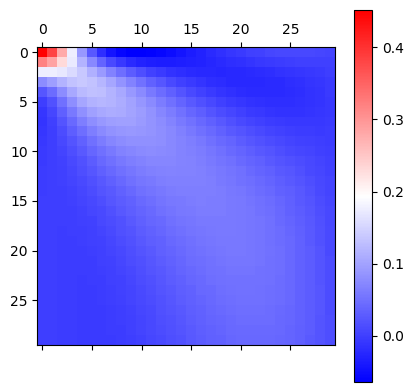

PyObject <matplotlib.colorbar.Colorbar object at 0x14e24ea90>

In [198]:
matshow(transpose(RM[1:numlay-1, 1:numlay-1])) # Aufösung für thkVec = 30 Werte
#matshow(transpose(diag(RM)))
#clim(0, 0.1)
set_cmap("bwr")
colorbar()

Nun wird deutlich, dass die erste Schicht für $i = 2$ und $j = 3$ durch den Einfluss von kleinen Periodauern in der Größenordnung $10^{-3}s$ mit einem Wert von $0.4$ höher aufgelöst ist. Die Bereiche für $i,j > 3$ entlang der Diagonalen verzeichnen eine abnehmende Auflösung von $0.2 - 0.1$ in der ersten Schicht. Die zweite Schicht besitzt ab $i,j = 15$ Werte die kleiner als $0.1$ sind, sodass die gutleitende Schicht nicht realitätsnah im Inversionsergebnis abgebildet wird. Die geringe Auflösung der zweiten Schnitt und die gute Auflösung des zweiten Schichtübergangs wird auch in der alleinigen Abbildung der Diagonalen sichtbar. Auffällig ist zudem das während der Inversion in der zweiten und dritten Schicht nach den ersten beiden Iterationen die größten Abweichungen entstehen. In dem Bereich des Minimums der Kurve des scheinbaren spezifischen Widerstandes zwischen $T = 10^{-1} - 3 \cdot 10^{-1}$ ist zusätzlich der Misfit am größten. Die größeren Abweichungen in diesem Bereich können demnach auf das angewendete Rauschen zurückzuführen sein. Die Daten erreichen aus diesem Grund in der zweiten und auch in der dritten Schicht eine geringere Auflösung.

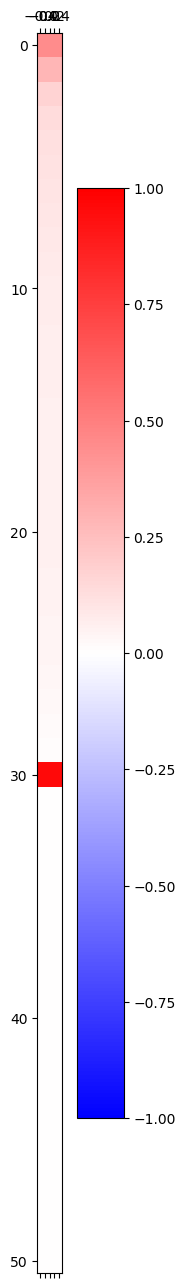

PyObject <matplotlib.colorbar.Colorbar object at 0x14d8df9d0>

In [199]:
DiagRM = diag(RM)
matshow(transpose(reshape(DiagRM, 1, length(RM[:,1]))))
set_cmap("bwr")
clim(-1, 1)
colorbar()

#### Informationsdichtematrix

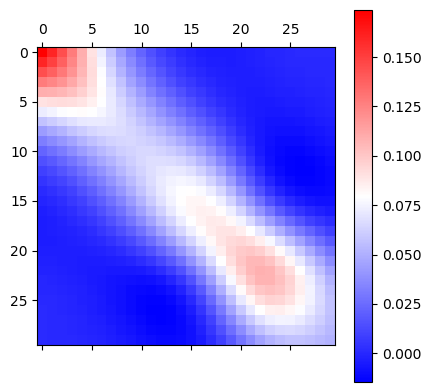

PyObject <matplotlib.colorbar.Colorbar object at 0x14abbc950>

In [200]:
lambda = lambda_opt  # 10, 1, 0.1
STS = transpose(Sens) * Sens
CTC = transpose(C) * C
RD = Sens * inv(STS + CTC .* lambda^2) * transpose(Sens)
matshow(transpose(RD[1:numlay-1, 1:numlay-1]))
#clim(-1, 1)
set_cmap("bwr")
colorbar()

Die Informationsdichtematrix $\mathbf R^D_{ij}$ zeigt ebenfalls eine deutlich höhere Wichtung der Daten mit bis zu $0.16$ in der ersten Schicht zwischen $i,j = 0$ und $i,j = 5$ an. Dort befindet sich ein lokales Maximum und der 1.Wendepunkt in der Sondierungskurve, sodass eine erhöhte Anzahl an Daten benötigt wird, um den Verlauf des scheinbaren spezifischen Widerstandes korrekt darzustellen. Bis zum Übergang zur zweiten Schicht bei $i = 15$ nimmt die Dichte der Daten immer ab. In der zweiten Schicht liegt dann das Minimum für die Abbildung der gutleitenden Schicht. Bis zum Minimum bei $i,j = 24$ bzw. $i,j = 25$ nimmt die Informationsdichte zu und erreicht einen Wert von ca. $0.125$. Auch in der Darstellung der Diagonalen sind erhöhte Werte in der ersten Schicht und in der Umgebung des Minimums festzustellen. Die dritte Schicht besitzt hingegen eine sehr geringe Informationsdichte (siehe untere Abbildung).

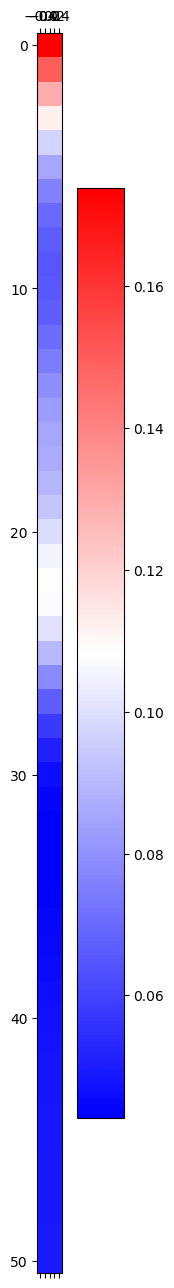

PyObject <matplotlib.colorbar.Colorbar object at 0x14f3fbfd0>

In [201]:
DiagRD = diag(RD)
matshow(transpose(reshape(DiagRD, 1, length(RD[:,1]))))
set_cmap("bwr")
#clim(0, 0.16)
colorbar()

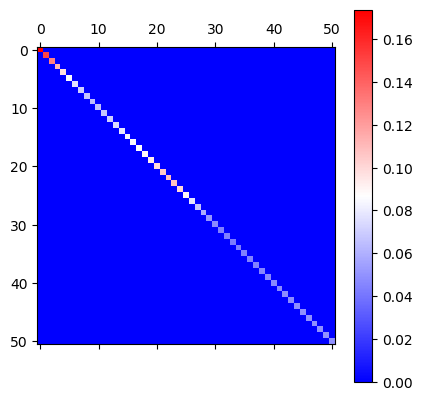

PyObject <matplotlib.colorbar.Colorbar object at 0x14e273cd0>

In [154]:
RDd = zeros(length(RD[:,1]),length(RD[:,1]))
RDd = Diagonal(RD)
matshow(RDd)
set_cmap("bwr")
colorbar()

## Only Lambda-Test

In [202]:
resistivity = ones(length(T)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)

C = zeros(length(T) - 1, length(T))
for i = 1:length(T)-1,
    C[i, i] = -1
    C[i, i+1] = +1
end

lambdaVector = 10 .^ range(-2, 2, step=0.1)
n = length(lambdaVector)
#n = 10

deltamodel = zeros(n)

modelNorm1 = zeros(n)
residualNorm1 = zeros(n)
modelNorm = zeros(n*l)
residualNorm = zeros(n*l)
residual = zeros(n)
chi1 = zeros(n)
chi = zeros(n)
chi_lam = zeros(l,n)

numlay = length(thkVec) + 1
Sens = MT1dSensLog(T, resistivity)
Sens = Sens ./ errmodel
    
for i = 1:n
    
    resistivity = ones(length(T)) * 100
    rhoa, phase = mt1dsmooth(T, resistivity)
    
    d = log.(rhoa_syn) .- log.(rhoa)
    
    lambda = lambdaVector[i]
    
    
    deltamodel = OccamTest(Sens, C, lambda, d, errmodel)
    
    resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
    rhoa, phase = mt1dsmooth(T, resistivity) 
    
    modelNorm1[i] = norm(C * rhoa)
    residual = (Sens * log.(rhoa) .- log.(rhoa_syn)) ./ errmodel
    residualNorm1[i] = norm(residual)
    chi1[i] = sum(residual.^2) / length(rhoa)
           
    
end



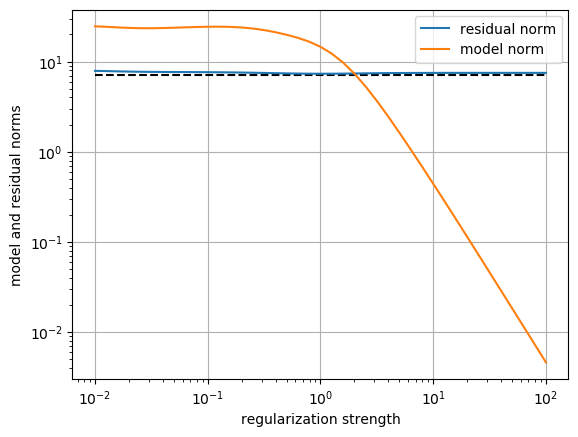

In [203]:
loglog(lambdaVector, residualNorm1, label="residual norm")
loglog(lambdaVector, modelNorm1, label="model norm")
hlines(sqrt(length(rhoa)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

In [204]:
pp = argmin(abs.(chi1 .- 1))
lambda_opt = lambdaVector[pp]

1.0

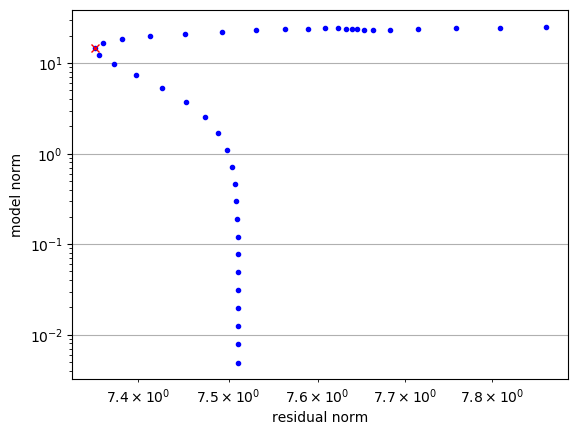

Optimum p after discrepancy principle: 21

In [187]:
#pp = argmin(abs.(chi .- 1))
print("Optimum p after discrepancy principle: ", pp)
loglog(residualNorm1, modelNorm1, "b.")
loglog(residualNorm1[pp], modelNorm1[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

## Gaus-Newton

In [273]:
function GausNewton(rhoa_syn, rhoa, phase, resistivity, T, C, lambda, i, error)
#     Srhoa, Sphi = MT1dSens(T, resistivity)
    Srhoa = MT1dSensLog(T, resistivity)
    Srhoa = Srhoa ./ error
    deltaRhoa = (log.(rhoa_syn) .- log.(rhoa)) ./ error  # = (d - f(m))
    ST = transpose(Srhoa)
    CTC = transpose(C) * C
    deltaRes = inv(ST * Srhoa .+ CTC * lambda^2) * (ST * deltaRhoa .- CTC * log.(resistivity) * lambda^2)
    # deltaModel = inv(ST * Slog .+ CTC * lambda) * (ST * deltaData)
    resistivity = resistivity .* exp.(deltaRes) # update of resistivity values
    rhoa, phase = mt1dsmooth(T, resistivity) #./ error
    #display(sqrt(mean(((rhoa_syn .- rhoa)./rhoa_syn).^2)) * 100)
    #chi = sum((rhoa_syn .- rhoa) ./ errmodel)^2 ./ length(T)
    #display(chi)
    loglog(rhoa, T, marker="x", label=string(i))
    
    return deltaRes, resistivity, deltaRhoa, rhoa, phase, Srhoa
end

Occam (generic function with 1 method)

1556.6971991180528

56.60729441608418

5.59519413608583

3.1404389959282515

3.3802404990368693

3.353632735236356

3.3565641418169387

3.3562538063035454

3.3562874098269293

3.3562838491622777

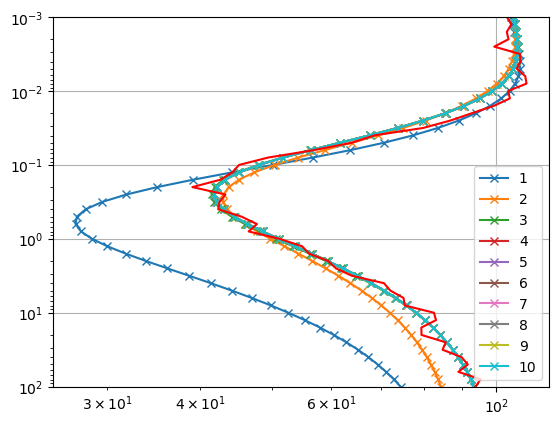

In [274]:
numlay = length(thkVec) + 1
err = 0.03
resistivity = ones(length(T)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)
C = zeros(length(T) - 1, length(T))
for i = 1:length(T)-1,
    C[i, i] = -1
    C[i, i+1] = +1
end

lambda = 0.3
#lambdaVector = 10 .^ range(-3, 1, step=0.1)
#l = length(lambdaVector)

n = 10
deltaRes = zeros(length(T))
deltaRhoa = zeros(length(T)*n)
deltaRhoa1 = zeros(length(T)*n)
chi = zeros(n)

#delta_lam = zeros(length(T)*n, l)

#for j = 1:l
    
for i = 1:n
    
    deltaRes, resistivity, deltaRhoa1, rhoa, phase, Srhoa = GausNewton(rhoa_syn, rhoa, phase, resistivity, T, C, lambda, i, errmodel)
    chi[i] = sum((rhoa_syn .- rhoa) ./ errmodel)^2 ./ length(T)
    display(chi[i])
    
    deltaRhoa[((length(T)*(i-1))+1):(length(T)*i)] = deltaRhoa1
        
end
    
#    delta_lam[j, 1:end] = deltaRhoa

#end

loglog(rhoa_syn, T, "r-")
ylim(maximum(T), minimum(T))
#xlim(80, 2000)
grid();
legend();

#(i-1)+(length(T)*n)

121.31331017829842

34.21982485104339

4.002480191638061

0.8750994883994517

0.8735934900822073

0.8729721397055117

0.8729881849383124

0.8729871743873647

0.872986814172245

0.872986882226723

0.8729868685785348

0.872986870726336

0.8729868703863785

0.8729868704371105

0.8729868704295729

0.8729868704306124

0.8729868704305564

0.872986870430556

0.8729868704302686

0.8729868704303155

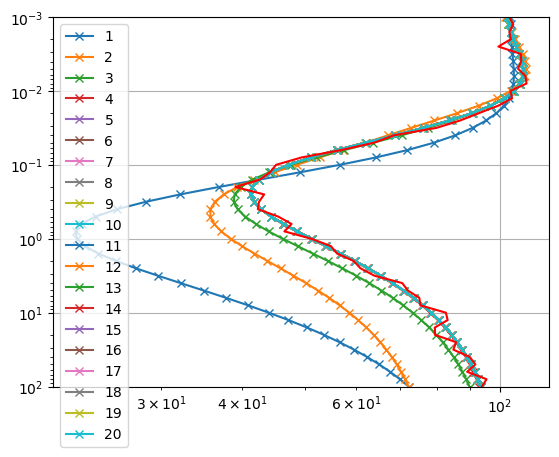

In [292]:
err = 0.03
resistivity = ones(length(T)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)
C = zeros(length(T) - 1, length(T))
for i = 1:length(T)-1,
    C[i, i] = -1
    C[i, i+1] = +1
end

lambda = lambda_opt
#lambda = 0.3
#lambdaVector = 10 .^ range(-3, 1, step=0.1)
#l = length(lambdaVector)

n = 20
deltaRes = zeros(length(T))
deltaRhoa = zeros(length(T)*n)
deltaRhoa1 = zeros(length(T)*n)
modelNorm = zeros(n)
residualNorm = zeros(n)
residual = zeros(n)
chi = zeros(n)
#Srhoa = zeros(length(T))

#delta_lam = zeros(length(T)*n, l)

#for j = 1:l
    
for i = 1:n
    
    deltaRes, resistivity, deltaRhoa1, rhoa, phase, Srhoa = Occam(rhoa_syn, rhoa, phase, resistivity, T, C, lambda, i, errmodel)
    modelNorm[i] = norm(C * rhoa_syn)
    residual = (rhoa_syn .- rhoa) ./ errmodel
    residualNorm[i] = norm(residual)
    chi[i] = sum(residual.^2) / length(T)
    display(chi[i])
    
    deltaRhoa[((length(T)*(i-1))+1):(length(T)*i)] = deltaRhoa1 #./ errmodel
        
end
    
#    delta_lam[j, 1:end] = deltaRhoa

#end

loglog(rhoa_syn, T, "r-")
ylim(maximum(T), minimum(T))
#xlim(80, 2000)
grid();
legend();

#(i-1)+(length(T)*n)

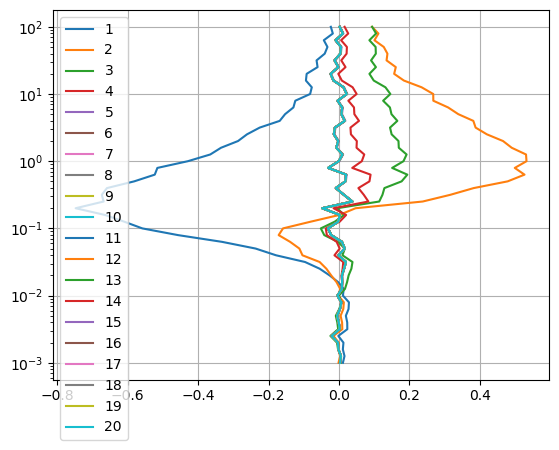

In [293]:
for i = 1:n
    
    semilogy(deltaRhoa[((length(T)*(i-1))+1):(length(T)*i)], T, label=string(i))

end

grid();
legend();

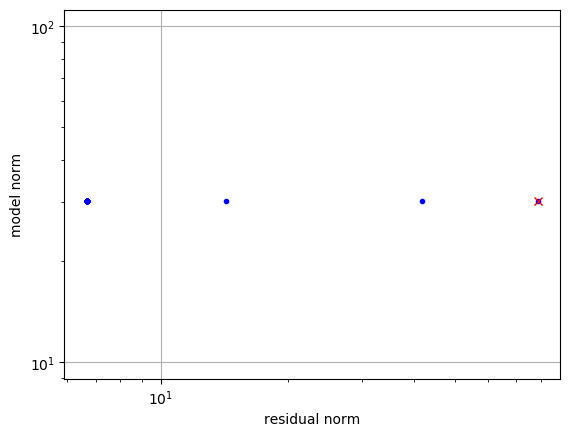

In [294]:
loglog(residualNorm, modelNorm, "b.")
loglog(residualNorm[lambda_ind[1]], modelNorm[lambda_ind[1]], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

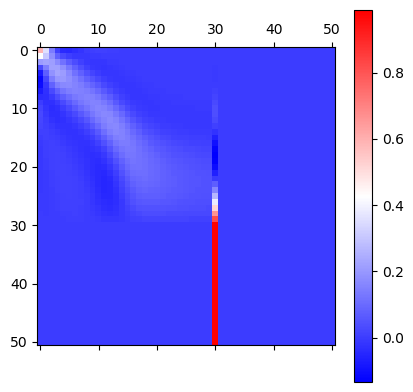

PyObject <matplotlib.colorbar.Colorbar object at 0x156963310>

In [295]:
STS = transpose(Srhoa) * Srhoa
CTC = transpose(C) * C
RM = inv(STS + CTC .* lambda^2) * (STS)
matshow(RM);
#clim(-1, 1)
set_cmap("bwr")
colorbar()

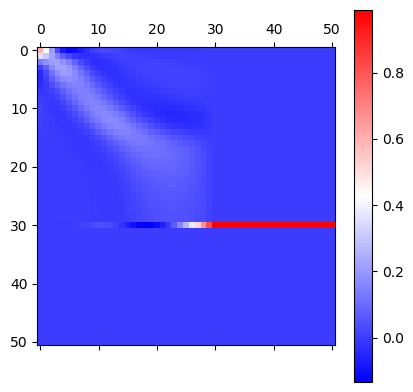

PyObject <matplotlib.colorbar.Colorbar object at 0x15918d3d0>

In [296]:
RD = STS * pinv(STS + CTC .* lambda^2)
matshow(RD);
#clim(-1, 1)
set_cmap("bwr")
colorbar()

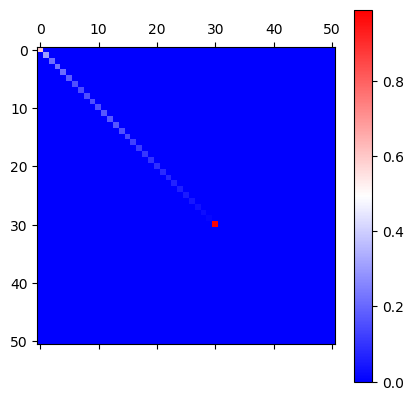

PyObject <matplotlib.colorbar.Colorbar object at 0x159354390>

In [297]:
Rd = zeros(length(RD[:,1]),length(RD[:,1]))
Rd = Diagonal(RM)
matshow(Rd)
set_cmap("bwr")
colorbar()

## Tiefenmodell

In [92]:
function Occam2(rhoa_syn, rhoa, phase, resistivity, T, C, lambda, i)
     Srhoa, Sphi = MT1dSens(T, resistivity)
    deltaRhoa = log.(rhoa_syn) .- log.(rhoa)
    ST = transpose(Srhoa)
    CTC = transpose(C) * C
    deltaRes = inv(ST * Srhoa .+ CTC * lambda^2) * (ST * deltaRhoa .- CTC * log.(resistivity) * lambda^2)
    # deltaModel = inv(ST * Slog .+ CTC * lambda) * (ST * deltaData)
    resistivity = resistivity .* exp.(deltaRes) # update of resistivity values
    rhoa, phase = mt1dsmooth(T, resistivity)
    #display(sqrt(mean(((rhoa_syn .- rhoa)./rhoa_syn).^2)) * 100)
    #chi = sum((rhoa_syn .- rhoa) ./ errmodel)^2 ./ length(T)
    #display(chi)
    semilogx(resistivity, z, marker="x", label=string(i))
    
    return deltaRes, resistivity, deltaRhoa, rhoa, phase
end

Occam2 (generic function with 1 method)

2016.6515606685255

3749.056436028022

532.057072576309

560.1438711047268

74.51569395501889

5.122944879570599

0.16052664554782597

0.01686716117115206

0.00667794695422528

0.012778466216045399

0.016710394171713047

0.016267153977097243

0.013711689863986258

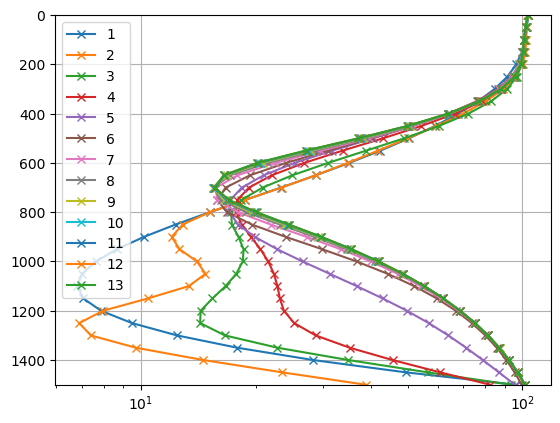

In [93]:
z = cumsum(vcat(0, thkVec))
resistivity = ones(length(z)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)
C = zeros(length(thkVec), length(thkVec) + 1)
for i = 1:length(thkVec),
    C[i, i] = -1
    C[i, i+1] = +1
end
lambda = lambda_opt

n = 13
deltaRes = zeros(length(T))
deltaRhoa = zeros(length(T))
chi = zeros(n)

for i = 1:n
    
    deltaRes, resistivity, deltaRhoa, rhoa, phase = Occam2(rhoa_syn, rhoa, phase, resistivity, T, C, lambda, i)
    chi[i] = sum((rhoa_syn .- rhoa) ./ errmodel)^2 ./ length(T)
    display(chi[i])
end

#loglog(rhoa_syn, T, "r-")
ylim(maximum(z), minimum(z))
#xlim(80, 2000)
grid();
legend();

## Amplituden- und Phasen-Daten

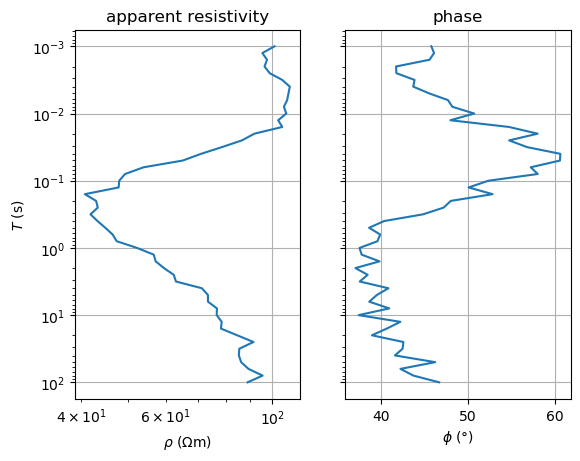

In [206]:
phi = 1
absphi = phi * pi / 180

phi_syn += randn(size(phi_syn)) .* absphi

rp_syn = vcat(rhoa_syn,phi_syn)
errmodel_pr = zeros(length(rp_syn),1)

errmodel_pr[1:length(rhoa_syn),1] = errmodel
errmodel_pr[length(rhoa_syn)+1:length(rhoa_syn)+length(phi_syn),1] .= absphi

plotMTsounding(T, rhoa_syn, phi_syn)

### Jacobi-Matrix

In [207]:
using LinearAlgebra  # Diagonal
function MT1dSensLogRP(T, resistivity)
    rhoa, phi = mt1dsmooth(T, resistivity)
    Srhoa, Sphi = MT1dSens(T, resistivity)
    Srho = Diagonal(1.0 ./ rhoa) * Srhoa * Diagonal(resistivity)
    Sp = Diagonal(1.0 ./ phi) * Sphi * Diagonal(resistivity)
    Slog = vcat(Srho,Sp)
    return Slog
end

MT1dSensLogRP (generic function with 1 method)

### Occam-Inversion

In [208]:
function OccamRhoPhi(Sens, C, lambda, d , error)
#function OccamTest(Sens, C, lambda, d , rhoa_syn, error)
    
    ST = transpose(Sens)
    #STd = ST * ((rhoa_syn .- d) ./ error) 
    STd = ST * (d ./ error) 
    CTCl = transpose(C) * C .* lambda^2
    model = inv(ST * Sens + CTCl) * STd 
    
    return model
    
end 

OccamRhoPhi (generic function with 1 method)

### Regularisierung

In [247]:
resistivity = ones(length(T)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)
rp = vcat(rhoa,phase)

#C = zeros(length(T) - 1, length(T))
#for i = 1:length(T)-1,
#    C[i, i] = -1
#    C[i, i+1] = +1
#end

C = zeros(length(rp) - 1, length(rp))
for i = 1:length(rp)-1,
    C[i, i] = -1
    C[i, i+1] = +1
end

lambdaVector = 10 .^ range(0, 4, step=0.1)
l = length(lambdaVector)
n = 20

#deltamodel = zeros(n)
deltamodel = zeros(length(rp))

modelNorm1R = zeros(n)
residualNorm1R = zeros(n)
#modelNorm = zeros(n*l)
#residualNorm = zeros(n*l)
residualR = zeros(n)
chi1R = zeros(n)
chiR = zeros(n)
chi_lamR = zeros(l,n)
modelNormR = zeros(l,n)
residualNormR = zeros(l,n)

modelNorm1P = zeros(n)
residualNorm1P = zeros(n)
#modelNorm = zeros(n*l)
#residualNorm = zeros(n*l)
residualP = zeros(n)
chi1P = zeros(n)
chiP = zeros(n)
chi_lamP = zeros(l,n)
modelNormP = zeros(l,n)
residualNormP = zeros(l,n)

numlay = length(thkVec) + 1
Sens = zeros(length(rp),length(rp))
Sens[:,1:51] = MT1dSensLogRP(T, resistivity)
Sens = Sens ./ errmodel_pr


for j = 1:l
    
    resistivity = ones(length(rp)) * 100
    rhoa, phase = mt1dsmooth(T, resistivity)
    rp = vcat(rhoa,phase)

    lambda = lambdaVector[j]
    
    for i = 1:n
        
   
        d = log.(rp_syn) .- log.(rp)
    
        deltamodel = OccamRhoPhi(Sens, C, lambda, d, errmodel_pr)
    
        resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
        rhoa, phase = mt1dsmooth(T, resistivity) 
        rp = vcat(rhoa,phase)
    
        modelNorm1R[i] = norm(C[1:50,1:51] * rp[1:51])
        residualR = (Sens[1:51,1:51] * log.(rp[1:51]) .- log.(rp_syn[1:51])) ./ errmodel_pr[1:51]
        residualNorm1R[i] = norm(residualR)
        chi1R = sum(residualR.^2) / length(rp[1:51])
        
        chiR[(i-1)+1] = chi1R
        
        modelNorm1P[i] = norm(C[52:101,52:102] * rp[52:102])
        residualP = (Sens[1:51,1:51] * log.(rp[52:102]) .- log.(rp_syn[52:102])) ./ errmodel_pr[52:102]
        residualNorm1P[i] = norm(residualP)
        chi1P = sum(residualR.^2) / length(rp[52:102])
        
        chiP[(i-1)+1] = chi1P
    
    end
    
    #residualNorm[((n*(j-1))+1):(n*j)] = residualNorm1
    #modelNorm[((n*(j-1))+1):(n*j)] = modelNorm1
    
    chi_lamR[j,1:end] = chiR
    
    modelNormR[j,1:end] = modelNorm1R
    residualNormR[j,1:end] = residualNorm1R
    
    
    chi_lamP[j,1:end] = chiP
    
    modelNormP[j,1:end] = modelNorm1P
    residualNormP[j,1:end] = residualNorm1P
    
end



In [248]:
lambda_indR = argmin(abs.(chi_lamR .- 1))
lambda_optR = lambdaVector[lambda_indR[1]]

lambda_indP = argmin(abs.(chi_lamP .- 1))
lambda_optP = lambdaVector[lambda_indP[1]]

lambda_opt = min(lambda_optR,lambda_optP)

12.589254117941675

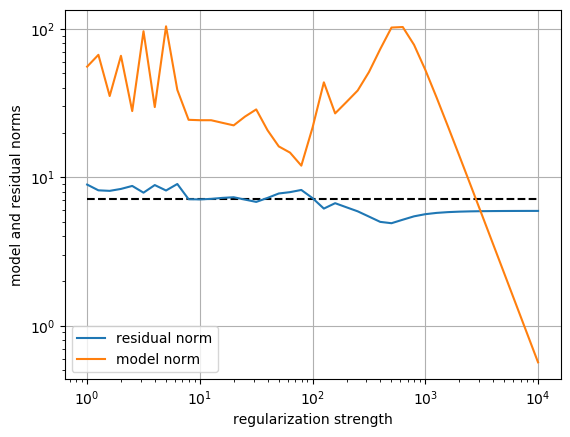

In [228]:
loglog(lambdaVector, residualNormR[:,lambda_indR[2]], label="residual norm")
loglog(lambdaVector, modelNormR[:,lambda_indR[2]], label="model norm")
hlines(sqrt(length(rp[1:51])), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

### Nonlinear Inversion

0.9815344639565898

1.0994639393165762

1.098880577245182

1.0678438760567541

1.0161614314977898

0.967024625266406

0.9500640684786542

0.9738430898602851

1.0125422610948513

1.037293042905232

1.0387440403797108

1.022270711882263

1.0003428293427246

0.9874058768846476

0.9913144505872997

1.0066439559842923

1.0207740550414537

1.0252726041759785

1.0198451843875367

1.0100503841675414

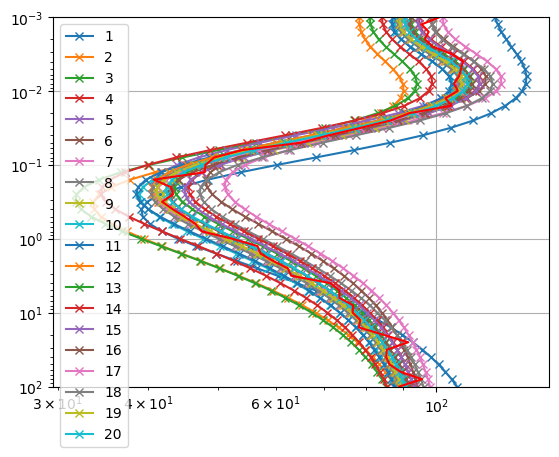

In [249]:
 using Statistics
resistivity = ones(length(T)) * 100
#lambda = lambdaVector[pp] 
lambda = lambda_opt
#lambda = 10
#lambda = 0.001
rhoa = zeros(n)
modelres = zeros(n)

#rhoa, phase = mt1dsmooth(T, resistivity)
#rp = vcat(rhoa,phase)

l = 20

#deltamodel = zeros(n)
modelNorm = zeros(l)
residualNorm = zeros(l)
residual = zeros(l)
chi = zeros(l)
#deltamodel = zeros(l)
d = zeros(length(rp))
misfit = zeros(l,length(rp))

rp_all = zeros(l,length(rp))

numlay = length(thkVec) + 1
Sens = zeros(length(rp),length(rp))
Sens[:,1:51] = MT1dSensLogRP(T, resistivity)
Sens = Sens ./ errmodel_pr

resistivity = ones(length(rp)) * 100
rhoa, phase = mt1dsmooth(T, resistivity)
rp = vcat(rhoa,phase)

for i = 1:l
    
    #resistivity = ones(length(rp)) * 100
    #rhoa, phase = mt1dsmooth(T, resistivity)
    #rp = vcat(rhoa,phase)
    
    d = log.(rp_syn) .- log.(rp)
    misfit[i,1:end] = d./errmodel_pr
    
    deltamodel = OccamRhoPhi(Sens, C, lambda, d, errmodel_pr)
    
    #deltam = (log.(rhoa_syn) .- modelres) ./ errmodel
    
    resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
    rhoa, phase = mt1dsmooth(T, resistivity) 
    rp = vcat(rhoa,phase)
    
    #resistivity = resistivity + deltam  # add line search
    #rhoa, phase = mt1dsmooth(T, resistivity)

    modelNorm[i] = norm(C[1:50,1:51] * rp[1:51])
    #residual = (Sens * rhoa .- rhoa_syn) ./ errmodel
    residual = (Sens[1:51,1:51] * log.(rp[1:51]) .- log.(rp_syn[1:51])) ./ errmodel_pr[1:51]
    residualNorm[i] = norm(residual)
    chi[i] = sum(residual[1:51].^2) / length(rp[1:51])
    display(chi[i])
    
    #display(sqrt(mean(((rhoa_syn .- rhoa)./rhoa_syn).^2)) * 100)
    
    loglog(rp[1:51], T, marker="x", label=string(i))
    
    rp_all[(i-1)+1,1:end] = rp

end


loglog(rp_syn[1:51], T, "r-")
ylim(maximum(T), minimum(T))
grid();
legend();

1.0252726041759785

1.0198451843875367

1.0100503841675414

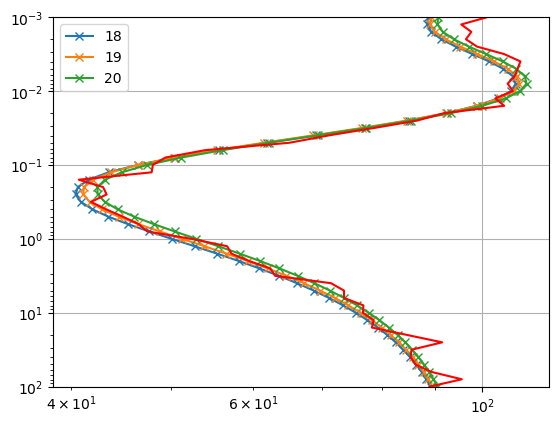

In [251]:
k = 20
n = 2

for i  = (k-n):k
        
    loglog(rp_all[i,1:51], T, marker="x", label=string(i))
    
    display(chi_lamR[lambda_indR[1],i])
    
end

loglog(rp_syn[1:51], T, "r-")
ylim(maximum(T), minimum(T))
grid();
legend();

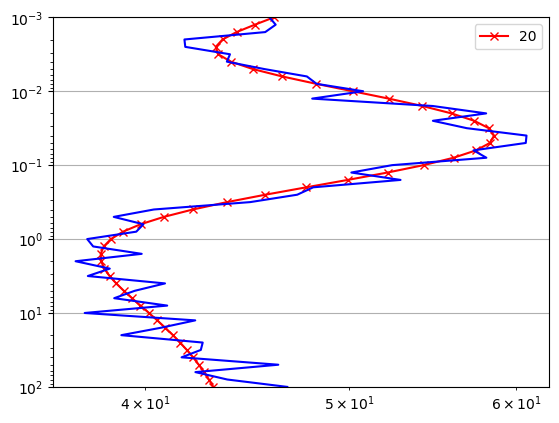

In [230]:
loglog(rp[52:102].* 180 ./ pi, T, "rx-", label=string(l))
loglog(rp_syn[52:102].* 180 ./ pi, T, "b-")
ylim(maximum(T), minimum(T))
grid();
legend();
#phi*180/pi

### Auflösung

#### Modellauflösungsmatrix

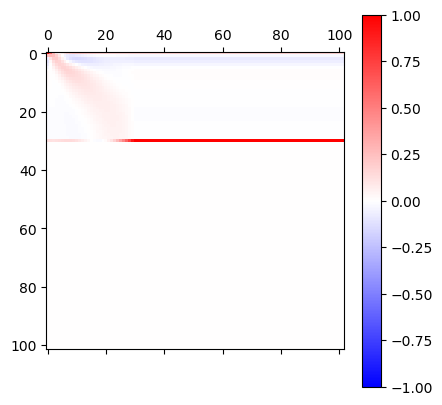

PyObject <matplotlib.colorbar.Colorbar object at 0x14ec14c90>

In [231]:
#Sens = MT1dSensLog(T, resistivity)
#Srhoa, Sphi = MT1dSens(T, resistivity)
lambda = lambda_opt 
STS = transpose(Sens) * Sens
CTC = transpose(C) * C
RM = pinv(STS + CTC .* lambda^2) * (STS)
#showModel(reshape(diag(RM),(nx,ny)), nx, ny, false)
#Rd = transpose(reshape(diag(RM[1:100,1:100]), 10, 10))
matshow(transpose(RM))
#matshow(transpose(diag(RM)))
clim(-1, 1)
set_cmap("bwr")
colorbar()

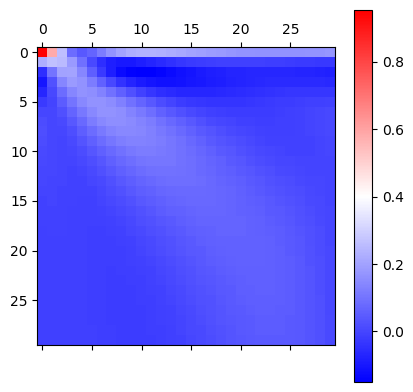

PyObject <matplotlib.colorbar.Colorbar object at 0x1534eaa50>

In [260]:
matshow(transpose(RM[1:numlay-1, 1:numlay-1]))
#matshow(transpose(diag(RM)))
#clim(-1, 1)
set_cmap("bwr")
colorbar()

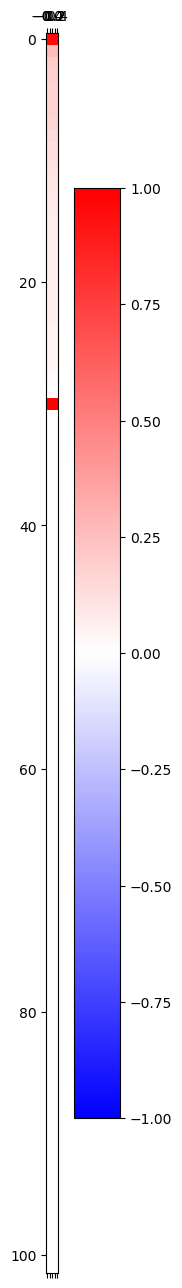

PyObject <matplotlib.colorbar.Colorbar object at 0x14e408dd0>

In [233]:
#Rd = zeros(length(RM[:,1]),length(RM[:,1]))
#Rd = Diagonal(RM)
DiagRM = diag(RM)
matshow(transpose(reshape(DiagRM, 1, length(RM[:,1]))))
set_cmap("bwr")
clim(-1, 1)
colorbar()

#### Informationsdichtematrix

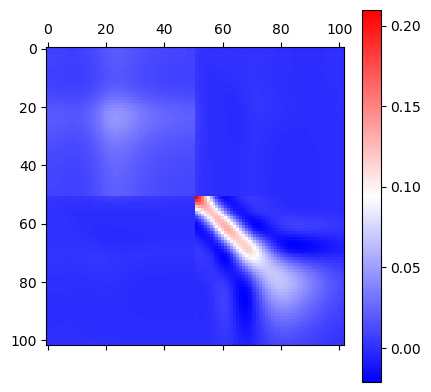

PyObject <matplotlib.colorbar.Colorbar object at 0x150a1c810>

In [254]:
lambda = lambda_opt  # 10, 1, 0.1
STS = transpose(Sens) * Sens
CTC = transpose(C) * C
RD = Sens * inv(STS + CTC .* lambda^2) * transpose(Sens)
matshow(transpose(RD))
set_cmap("bwr")
colorbar()

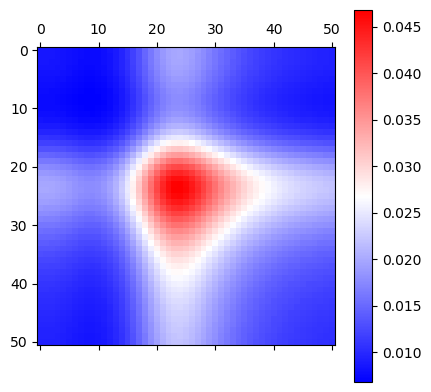

PyObject <matplotlib.colorbar.Colorbar object at 0x152fb6950>

In [257]:
matshow(transpose(RD[1:length(T), 1:length(T)]))
#clim(-1, 1)
set_cmap("bwr")
colorbar()

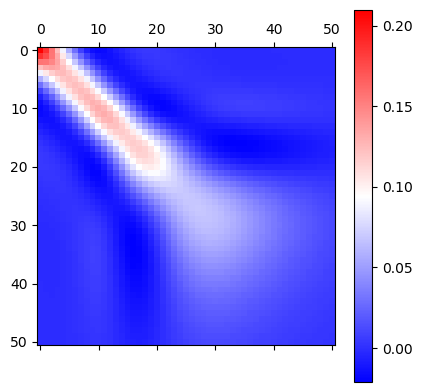

PyObject <matplotlib.colorbar.Colorbar object at 0x153169b50>

In [258]:
matshow(transpose(RD[length(T)+1:end, length(T)+1:end]))
#clim(-1, 1)
set_cmap("bwr")
colorbar()

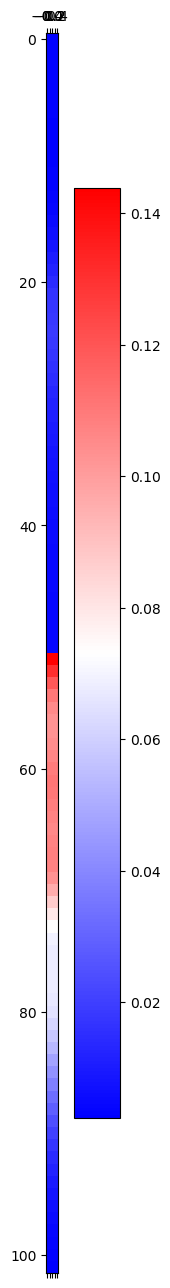

PyObject <matplotlib.colorbar.Colorbar object at 0x14b9cdc10>

In [80]:
DiagRD = diag(RD)
matshow(transpose(reshape(DiagRD, 1, length(RD[:,1]))))
set_cmap("bwr")
#clim(-1, 1)
colorbar()

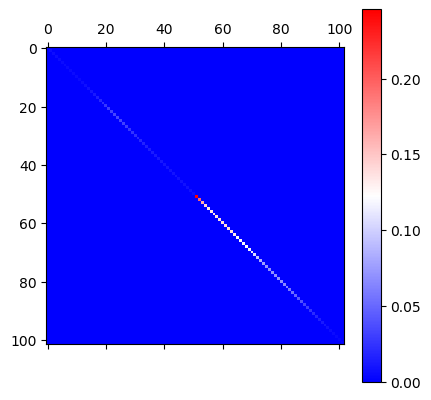

PyObject <matplotlib.colorbar.Colorbar object at 0x142721090>

In [379]:
RDd = zeros(length(RD[:,1]),length(RD[:,1]))
RDd = Diagonal(RD)
matshow(RDd)
set_cmap("bwr")
colorbar()

## Marquardt-Inversion

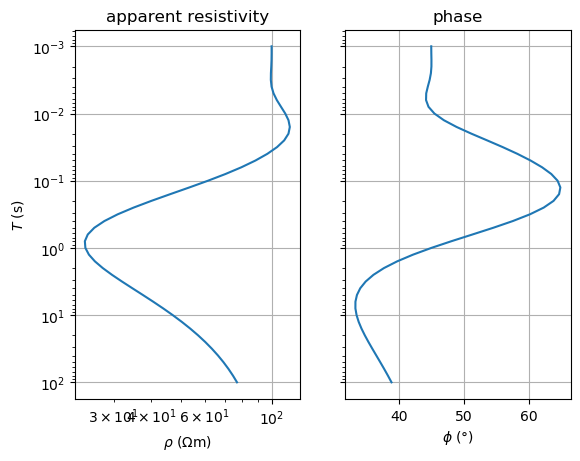

In [143]:
# Test the forward operator with a 3-layer model
rho_m = [100, 10, 100]
thk_m = [750, 750]
T = 10 .^ (-3:0.1:2)  # 1ms to 100s (typical AMT)
rhoa_syn_m, phi_syn_m = mt1dfwd(T, rho_m, thk_m)
#errmodel = ones(length(rhoa_syn),1) .* 0.03
#errmodel = 0.03 .* rhoa_syn
#rhoa_syn += randn(size(rhoa_syn)) .* errmodel #.* rhoa_syn 
plotMTsounding(T, rhoa_syn_m, phi_syn_m)

### Inversion

In [144]:
function Marquardt(Sens, IM, lambda, d)
#function OccamTest(Sens, C, lambda, d , rhoa_syn, error)
    
    ST = transpose(Sens)
    #STd = ST * ((rhoa_syn .- d) ./ error) 
    STd = ST * d 
    #CTCl = transpose(C) * C .* lambda^2
    #model = inv(ST * Sens + CTCl) * STd 
    
    model = inv(ST * Sens + IM .* lambda^2) * STd
    
    return model
    
end 

Marquardt (generic function with 2 methods)

### Regularisation

In [167]:
resistivity = ones(length(T)) * mean(rhoa_syn_m)
rhoa_m, phase_m = mt1dsmooth(T, resistivity)

nM = length(rhoa_m)
IM = Matrix(I, nM, nM)

lambdaVector = 10 .^ range(-1, 2, step=0.1)
l = length(lambdaVector)
n = 15

deltamodel = zeros(n)

modelNorm1 = zeros(n)
residualNorm1 = zeros(n)
#modelNorm = zeros(n*l)
#residualNorm = zeros(n*l)
residual = zeros(n)
rms1 = zeros(n)
rms = zeros(n)
rms_lam = zeros(l,n)
modelNorm = zeros(l,n)
residualNorm = zeros(l,n)

numlay = length(thkVec) + 1
Sens = MT1dSensLog(T, resistivity)
#Sens = Sens ./ errmodel


for j = 1:l
    
    resistivity = ones(length(T)) * mean(rhoa_syn_m)
    rhoa_m, phase_m = mt1dsmooth(T, resistivity)

    lambda = lambdaVector[j]
    
    for i = 1:n
        
   
        d = log.(rhoa_syn_m) .- log.(rhoa_m)
    
        deltamodel = Marquardt(Sens, IM, lambda, d)
    
        resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
        rhoa_m, phase_m = mt1dsmooth(T, resistivity) 
    
        modelNorm1[i] = norm(rhoa_m)
        residual = Sens * log.(rhoa_m) .- log.(rhoa_syn_m)
        residualNorm1[i] = norm(residual)
        
        #chi1 = sum(residual.^2) / length(rhoa)
        
        #chi[(i-1)+1] = chi1
        rms1 = sqrt(mean(((rhoa_syn_m .- rhoa_m)./rhoa_syn_m).^2)) * 100
        
        rms[(i-1)+1] = rms1
    
    end
    
    #residualNorm[((n*(j-1))+1):(n*j)] = residualNorm1
    #modelNorm[((n*(j-1))+1):(n*j)] = modelNorm1
    
    rms_lam[j,1:end] = rms
    
    modelNorm[j,1:end] = modelNorm1
    residualNorm[j,1:end] = residualNorm1
    
end



In [161]:
lambda_ind = argmin(abs.(rms_lam))
#lambda_optline = minimum(abs.(delta_lam))
lambda_opt = lambdaVector[lambda_ind[1]]

0.01

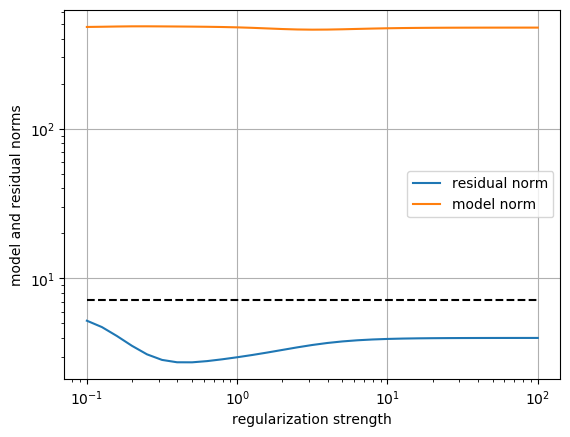

In [154]:
loglog(lambdaVector, residualNorm[:,1], label="residual norm")
loglog(lambdaVector, modelNorm[:,1], label="model norm")
hlines(sqrt(length(rhoa_m)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

39.20944111972827

19.423575546620242

49.17631276267174

14.804434592190455

8.331470025116571

3.212909565196159

2.749299547605995

1.1943536296692048

0.8939092755358412

0.49950835661232657

0.5130944514214067

0.46137357930922984

0.4327195638884387

0.4229670703196158

0.4284203245312575

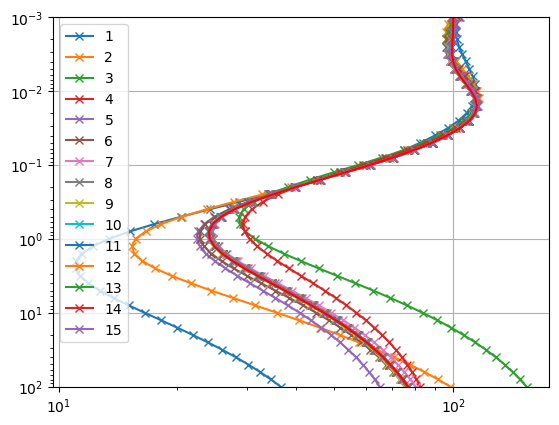

In [155]:
resistivity = ones(length(T)) * mean(rho_m)
rhoa_m, phase_m = mt1dsmooth(T, resistivity)

nM = length(rhoa_m)
IM = Matrix(I, nM, nM)

lambda = lambda_opt
#lambda = 0.3

l = 15

modelNorm = zeros(l)
residualNorm = zeros(l)
residual = zeros(l)
chi = zeros(l)
deltamodel = zeros(l)
d = zeros(length(rhoa_m))
misfit = zeros(l,length(rhoa_m))

rhoa_m_all = zeros(l,length(rhoa_m))

numlay = length(thkVec) + 1
Sens = MT1dSensLog(T, resistivity)
#Sens = Sens ./ errmodel

for i = 1:l
    
    d = log.(rhoa_syn_m) .- log.(rhoa_m)
    #misfit[i,1:end] = d./errmodel
    
    deltamodel = Marquardt(Sens, IM, lambda, d)
    
    #deltam = (log.(rhoa_syn) .- modelres) ./ errmodel
    
    resistivity = resistivity .* exp.(deltamodel) # update of resistivity value
    rhoa_m, phase_m = mt1dsmooth(T, resistivity) 
    
    #resistivity = resistivity + deltam  # add line search
    #rhoa, phase = mt1dsmooth(T, resistivity)

    modelNorm[i] = norm(IM * rhoa_m)
    #residual = (Sens * rhoa .- rhoa_syn) ./ errmodel
    residual = (Sens * log.(rhoa_m) .- log.(rhoa_syn_m)) #./ errmodel
    residualNorm[i] = norm(residual)
    #chi[i] = sum(residual.^2) / length(rhoa_m)
    #display(chi[i])
    
    display(sqrt(mean(((rhoa_syn_m .- rhoa_m)./rhoa_syn_m).^2)) * 100)
    
    loglog(rhoa_m, T, marker="x", label=string(i))
    
    rhoa_m_all[(i-1)+1,1:end] = rhoa_m

end


loglog(rhoa_syn_m, T, "r-")
ylim(maximum(T), minimum(T))
grid();
legend();

0.40590180535668785

0.4018162511062122

0.40324835341623244

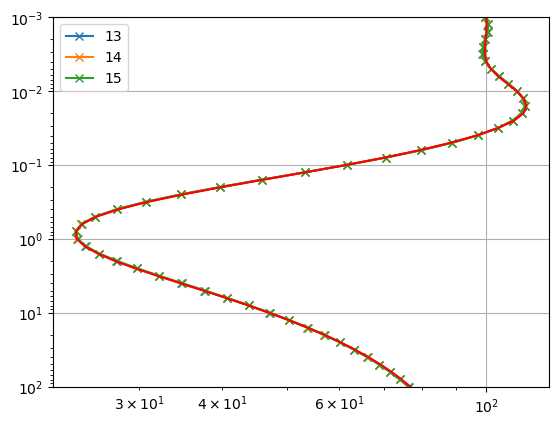

In [156]:
k = 15
n = 2

for i  = (k-n):k
        
    loglog(rhoa_m_all[i,1:end], T, marker="x", label=string(i))
    
    display(rms_lam[lambda_ind[1],i])
    
end

loglog(rhoa_syn_m, T, "r-")
ylim(maximum(T), minimum(T))
grid();
legend();

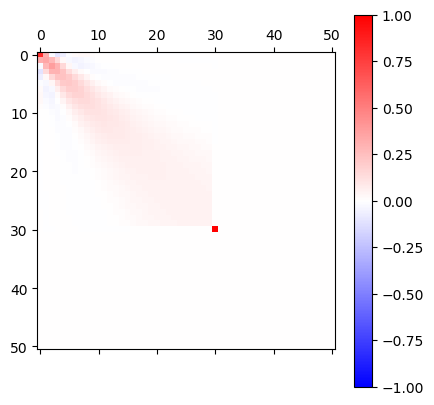

PyObject <matplotlib.colorbar.Colorbar object at 0x14dac4f90>

In [157]:
lambda = lambda_opt
STS = transpose(Sens) * Sens
ITI = transpose(IM) * IM
RM = pinv(STS + IM .* lambda^2) * (STS)
#showModel(reshape(diag(RM),(nx,ny)), nx, ny, false)
matshow(transpose(RM))
#matshow(transpose(diag(RM)))
clim(-1, 1)
set_cmap("bwr")
colorbar()

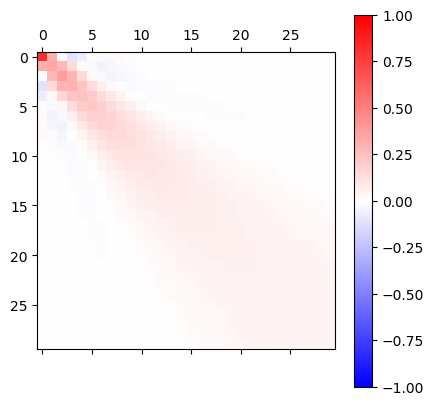

PyObject <matplotlib.colorbar.Colorbar object at 0x14cd02910>

In [158]:
matshow(transpose(RM[1:numlay-1, 1:numlay-1]))
#matshow(transpose(diag(RM)))
clim(-1, 1)
set_cmap("bwr")
colorbar()

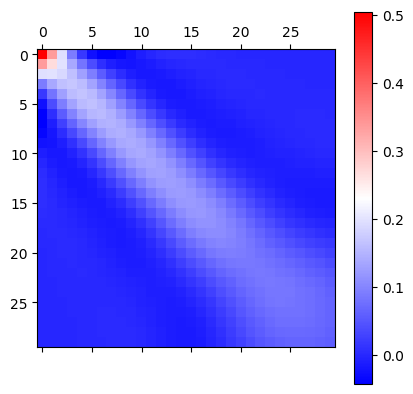

PyObject <matplotlib.colorbar.Colorbar object at 0x14d635490>

In [159]:
lambda = lambda_opt  # 10, 1, 0.1
STS = transpose(Sens) * Sens
#CTC = transpose(C) * C
RD = Sens * inv(STS + IM .* lambda^2) * transpose(Sens)
matshow(transpose(RD[1:numlay-1, 1:numlay-1]))
#clim(-1, 1)
set_cmap("bwr")
colorbar()